In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
import torchvision
from PIL import ImageDraw
import numpy as np
import matplotlib.image as imge

In [2]:
def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

In [3]:
def resize_img_label(image,label=(0.,0.),target_size=(256,256)):
  w_orig,h_orig = image.size
  w_target,h_target = target_size
  cx, cy= label

  image_new = TF.resize(image,target_size)
  label_new= cx/w_orig*w_target, cy/h_orig*h_target

  return image_new,label_new

In [4]:
def transformer(image, label, params):
  image,label=resize_img_label(image,label,params["target_size"])

  if params["scale_label"]:
      label=scale_label(label,params["target_size"])

  image=TF.to_tensor(image)
  return image, label

In [5]:
path2data = "/content/drive/MyDrive/01_Single_Object_Detection/Training400"

In [6]:
class AMD_dataset(Dataset):
    def __init__(self, path2data, transform, trans_params):
      path2labels=os.path.join(path2data,"Fovea_location.xlsx")

      labels_df=pd.read_excel(path2labels,index_col="ID")

      self.labels = labels_df[["Fovea_X","Fovea_Y"]].values

      self.imgName=labels_df["imgName"]
      self.ids=labels_df.index

      self.fullPath2img=[0]*len(self.ids)
      for id_ in self.ids:
        if self.imgName[id_][0]=="A":
          prefix="AMD"
        else:
          prefix="Non-AMD"

        self.fullPath2img[id_-1]=os.path.join(path2data,prefix,self.imgName[id_])

      self.transform = transform
      self.trans_params=trans_params

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
      image = Image.open(self.fullPath2img[idx])
      label= self.labels[idx]
      image,label = self.transform(image,label,self.trans_params)

      return image, label

In [7]:
trans_params_val = {
    "target_size" : (256, 256),
    "p_hflip" : 0.0,
    "p_vflip" : 0.0,
    "p_shift" : 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "gamma": 0.0,
    "scale_label": True,
                  }
amd_ds2 = AMD_dataset(path2data , transformer , trans_params_val)

In [8]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = range(len(amd_ds2))

for train_index, val_index in sss.split(indices):
  print(len(train_index))
  print("-"*10)
  print(len(val_index))

320
----------
80


In [9]:
from torch.utils.data import Subset
val_ds=Subset(amd_ds2,val_index)
print(len(val_ds))


80


In [10]:
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [11]:
class Net(nn.Module):
  def __init__(self, params):
    super(Net, self).__init__()

  def forward(self, x):
    return x

In [12]:
def __init__(self, params):
  super(Net, self).__init__()

  C_in,H_in,W_in=params["input_shape"]
  init_f=params["initial_filters"]
  num_outputs=params["num_outputs"]

  self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=2,padding=1)
  self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3,stride=1,padding=1)
  self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3,padding=1)
  self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3,padding=1)
  self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3,padding=1)
  self.fc1 = nn.Linear(16*init_f, num_outputs)

In [13]:
def forward(self, x):
  identity=F.avg_pool2d(x,4,4)
  x = F.relu(self.conv1(x))
  x = F.max_pool2d(x, 2, 2)
  x = torch.cat((x, identity), dim=1)

  identity=F.avg_pool2d(x,2,2)
  x = F.relu(self.conv2(x))
  x = F.max_pool2d(x, 2, 2)
  x = torch.cat((x, identity), dim=1)

  identity=F.avg_pool2d(x,2,2)
  x = F.relu(self.conv3(x))
  x = F.max_pool2d(x, 2, 2)
  x = torch.cat((x, identity), dim=1)

  identity=F.avg_pool2d(x,2,2)
  x = F.relu(self.conv4(x))
  x = F.max_pool2d(x, 2, 2)
  x = torch.cat((x, identity), dim=1)

  x = F.relu(self.conv5(x))

  x=F.adaptive_avg_pool2d(x,1)
  x = x.reshape(x.size(0), -1)

  x = self.fc1(x)
  return x

In [14]:
Net.__init__=__init__
Net.forward=forward

In [15]:
params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16,
        "num_outputs": 2,
            }

model = Net(params_model)
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model=model.to(device)

### **DEPLOY**

In [17]:
path2weights="/content/drive/MyDrive/01_Single_Object_Detection/model/weights_smoothl1.pt"
model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [18]:
device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
  running_loss=0.0
  running_metric=0.0
  len_data=len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    yb=torch.stack(yb,1)
    yb=yb.type(torch.float32).to(device)
    output=model(xb.to(device))
    loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
    running_loss+=loss_b
    if metric_b is not None:
        running_metric+=metric_b
    if sanity_check is True:
        break

  loss=running_loss/float(len_data)

  metric=running_metric/float(len_data)

  return loss, metric

def cxcy2bbox(cxcy,w=50./256,h=50./256):
  w_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*w
  h_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*h

  cx=cxcy[:,0].unsqueeze(1)
  cy=cxcy[:,1].unsqueeze(1)

  boxes=torch.cat((cx,cy, w_tensor, h_tensor), -1)  # cx,cy,w,h

  return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                    boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax

def metrics_batch(output, target):
  output=cxcy2bbox(output)
  target=cxcy2bbox(target)

  iou=torchvision.ops.box_iou(output, target)
  return torch.diagonal(iou, 0).sum().item()

def loss_batch(loss_func, output, target, opt=None):

  loss = loss_func(output, target)

  metric_b = metrics_batch(output,target)

  if opt is not None:
      opt.zero_grad()
      loss.backward()
      opt.step()

  return loss.item(), metric_b

In [19]:
loss_func=nn.SmoothL1Loss(reduction="sum")

with torch.no_grad():
  loss,metric=loss_epoch(model,loss_func,val_dl)
print(loss,metric)


0.009256786201149225 0.5662647724151612


In [43]:
def show_tensor_2labels(img, label1, label2, w_h=(50, 50), save_path=None):
    label1 = rescale_label(label1, img.shape[1:])
    label2 = rescale_label(label2, img.shape[1:])
    img = TF.to_pil_image(img)

    w, h = w_h
    cx, cy = label1
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx - w/2, cy - h/2), (cx + w/2, cy + h/2)), outline="green", width=2)

    cx, cy = label2
    draw.rectangle(((cx - w/2, cy - h/2), (cx + w/2, cy + h/2)), outline="red", width=2)

    if save_path:
        img.save(save_path)  # Save the image if a save path is provided

    plt.imshow(np.asarray(img))




### **Getting Random Sample**

In [48]:
rnd=np.random.randint(len(val_ds),size=10)
print(rnd)

[29 70 55 65 31 19 24 67 69 32]


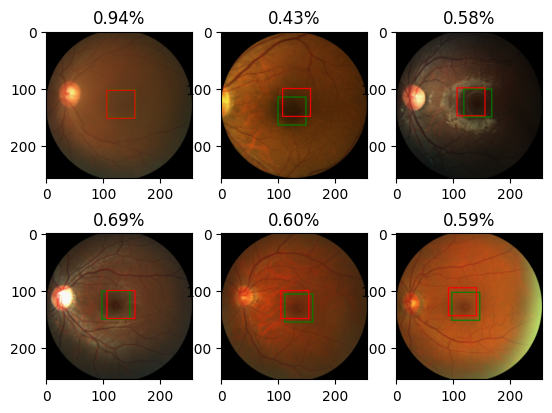

In [49]:
for i,rndi in enumerate(rnd):
  img,label=val_ds[rndi]
  h,w=img.shape[1:]
  with torch.no_grad():
      label_pred=model(img.unsqueeze(0).to(device))[0].cpu()

  plt.subplot(2,3,i+1)
  show_tensor_2labels(img,label,label_pred , save_path= f"/content/drive/MyDrive/01_Single_Object_Detection/OUTPUT/image{i}.png")

  label_bb=cxcy2bbox(torch.tensor(label).unsqueeze(0))
  label_pred_bb=cxcy2bbox(label_pred.unsqueeze(0))
  iou=torchvision.ops.box_iou(label_bb, label_pred_bb)
  plt.title(f"{iou.item():.2f}%")

  if i>4:
      break

In [50]:
def load_img_label(labels_df,id_):
  imgName=labels_df["imgName"]
  if imgName[id_][0]=="A":
      prefix="AMD"
  else:
      prefix="Non-AMD"

  fullPath2img=os.path.join(path2data,prefix,imgName[id_])
  img = Image.open(fullPath2img)

  x=labels_df["Fovea_X"][id_]
  y=labels_df["Fovea_Y"][id_]

  label=(x,y)
  return img,label

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)
torch.Size([3, 256, 256])


(-0.5, 255.5, 255.5, -0.5)

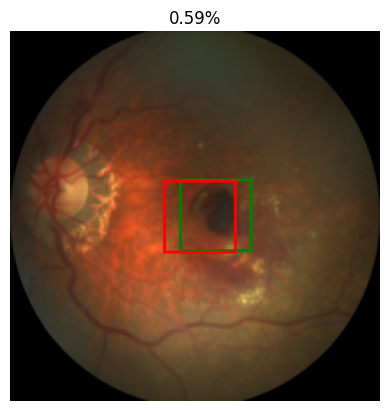

In [51]:
path2labels=os.path.join(path2data,"Fovea_location.xlsx")
labels_df=pd.read_excel(path2labels,index_col="ID")

img,label=load_img_label(labels_df,1)
print(img.size, label)

img,label=resize_img_label(img,label,target_size=(256,256))
print(img.size, label)

img=TF.to_tensor(img)
label=scale_label(label,(256,256))
print(img.shape)

with torch.no_grad():
  label_pred=model(img.unsqueeze(0).to(device))[0].cpu()

show_tensor_2labels(img,label,label_pred)
iou=torchvision.ops.box_iou(label_bb, label_pred_bb)
plt.title(f"{iou.item():.2f}%")
plt.axis("off")